<a href="https://colab.research.google.com/github/Akash-Git20/bitcoin_price_prediction/blob/main/Add_new_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import yfinance as yf
import os
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pytz
from sklearn.ensemble import RandomForestClassifier

In [3]:
tz = pytz.timezone("America/New_York")
start = tz.localize(dt(2014,1,1))
end = tz.localize(dt.today())
tickers = "BTC-USD"
df = yf.download(tickers,start, end, auto_adjust=True)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df.index = pd.to_datetime(df.index)

In [4]:
df["Tomorrow"] = df["Close"].shift(-1)
df["Target"] = (df["Tomorrow"] > df["Close"]).astype(int)

In [5]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train["Target"])
  preds = model.predict(test[predictors])
  preds = pd.Series(preds, index=test.index, name="Predictions")
  combined = pd.concat([test["Target"], preds], axis=1)
  return combined

In [6]:
from sklearn.metrics import precision_score
def get_precision_score(arr):
  return precision_score(arr["Target"], arr["Predictions"])

In [7]:
def backtest(data, model, predictors, start = 1050, step = 150):
  all_predictions = []
  for i in range(start, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i + step)].copy()
    predictions = predict(train, test, predictors, model)
    all_predictions.append(predictions)
  return pd.concat(all_predictions)

In [8]:
def compute_rolling(btc):
  horizons = [5, 10, 15]
  new_predictors = ["Close", "High", "Low", "Open", "Volume"]

  for horizon in horizons:
    rolling_averages = btc.rolling(horizon, min_periods=1).mean()

    ratio_column = f"close_ratio_{horizon}"
    btc[ratio_column] = btc["Close"] / rolling_averages["Close"]

    rolling = btc.rolling(horizon,closed="left",min_periods=1).mean()
    trend_column = f"trend_{horizon}"
    btc[trend_column] = rolling["Target"]

    new_predictors += [ratio_column, trend_column]

  return btc, new_predictors

In [9]:
new_df, predictors = compute_rolling(df.copy())
predictors

['Close',
 'High',
 'Low',
 'Open',
 'Volume',
 'close_ratio_5',
 'trend_5',
 'close_ratio_10',
 'trend_10',
 'close_ratio_15',
 'trend_15']

In [ ]:
new_df

,Open,High,Low,Close,Volume,Tomorrow,Target,close_ratio_5,trend_5,close_ratio_10,trend_10,close_ratio_15,trend_15
Date,,,,,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,424.440002,0,1.000000,NaN,1.000000,NaN,1.000000,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,394.795990,0,0.962696,0.000000,0.962696,0.000000,0.962696,0.000000
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,408.903992,1,0.927789,0.000000,0.927789,0.000000,0.927789,0.000000
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,398.821014,0,0.970419,0.333333,0.970419,0.333333,0.970419,0.333333
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,402.152008,1,0.956729,0.250000,0.956729,0.250000,0.956729,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-09,35633.632812,37926.257812,35592.101562,36693.125000,37762672382,37313.968750,1,1.031409,0.600000,1.040242,0.600000,1.050509,0.533333
2023-11-10,36702.250000,37493.800781,36362.753906,37313.968750,22711265155,37138.050781,0,1.035675,0.800000,1.049966,0.600000,1.061885,0.600000
2023-11-11,37310.070312,37407.093750,36773.667969,37138.050781,13924272142,37054.519531,0,1.018910,0.800000,1.040038,0.500000,1.050445,0.600000


In [10]:
from sklearn.linear_model import LogisticRegression
logisticModel = LogisticRegression(random_state=0)

In [11]:
train = new_df.iloc[:-200]
test = new_df.iloc[-200:]

In [12]:
train = train.dropna()
test = test.dropna()

In [13]:
predictions_LR = backtest(train, logisticModel, predictors)

In [24]:
models = []
accuracies = []

In [25]:
models.append("logistic regression")
accuracies.append(get_precision_score(predictions_LR))

In [15]:
from sklearn.ensemble import RandomForestClassifier
modelRF = RandomForestClassifier(n_estimators = 50, min_samples_split=50, random_state=1)

In [17]:
predictions_RF = backtest(train, modelRF, predictors)

In [26]:
models.append("random forests")
accuracies.append(get_precision_score(predictions_RF))

In [16]:
from xgboost import XGBClassifier
modelXGB = XGBClassifier(random_state = 1, learning_rate = .1, n_estimators=200)

In [20]:
predictions_XGB = backtest(train, modelXGB, predictors)

In [27]:
models.append("XGB")
accuracies.append(get_precision_score(predictions_XGB))

In [33]:
for i in range(len(accuracies)):
  accuracies[i] *= 100
model_compare = {models[i]:accuracies[i] for i in range(len(models))}

In [34]:
pd.DataFrame.from_dict(model_compare, orient='index', columns=['Accuracies'])

,Accuracies
logistic regression,51.980907
random forests,51.755176
XGB,51.242502


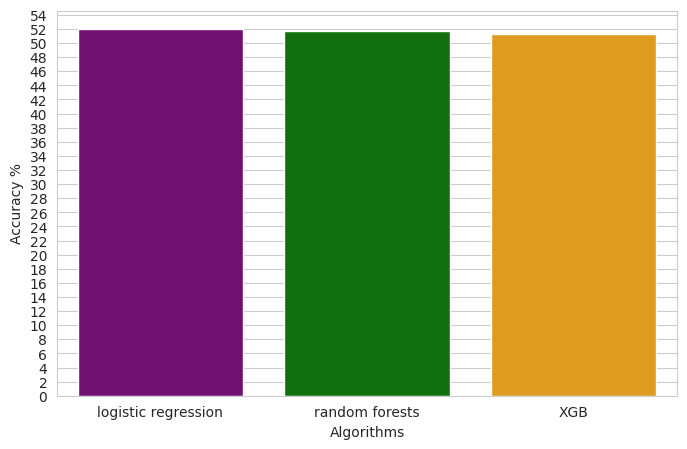

In [47]:
colors = ["purple", "green", "orange"]

sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
plt.yticks(np.arange(0,75,2))
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=list(model_compare.keys()), y=list(model_compare.values()), palette=colors)
plt.show()